In [1]:
#https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example/XGBoost%20models.ipynb
#https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
#https://www.kaggle.com/naokishibuya/xgboot-with-gridsearchcv

import pandas as pd
import numpy as np
import json
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection  import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
#load data
config = json.load(open('settings.json'))
train = pd.read_csv(config['train_modified'])
test = pd.read_csv(config['test_modified'])

In [3]:
train.shape,test.shape

((59381, 133), (19765, 133))

In [4]:
target='Response'
IDcol = 'Id'

In [5]:
#https://github.com/aarshayj/Analytics_Vidhya/issues/3: split train data into cv
#https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
from sklearn.model_selection import train_test_split
train_part, test_part = train_test_split(train, test_size=0.2)
#test_file2 = config['test_modified'].replace('.csv','_2p.csv')
#train_part.to_csv(test_file2)
#train_part = pd.read_csv(test_file2)
#test_part['Response']-=1
train_part['Response'].value_counts()

8    15589
6     8988
7     6470
2     5236
1     4968
5     4320
4     1132
3      801
Name: Response, dtype: int64

In [6]:
train_part.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47504 entries, 12979 to 47642
Columns: 133 entries, BMI to countna
dtypes: float64(19), int64(114)
memory usage: 48.6 MB


step 0- Define a function for modeling and cross-validation
This function will do the following:

fit the model
determine training accuracy
determine training AUC
  xx  determine testing AUC
update n_estimators with cv function of xgboost package
plot Feature Importance

In [34]:
def modelfit0(alg,dtrain,predictors,useTrainCV=True,cv_folds=5,early_stopping_rounds=100):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgbtrain = xgb.DMatrix(dtrain[predictors],label=dtrain[target])
        cvresult = xgb.cv( params=xgb_param,dtrain=xgbtrain,num_boost_round = alg.get_params()['n_estimators'],
                          nfold = cv_folds,metrics='mlogloss',early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors],dtrain['Response'],eval_metric='mlogloss')#'auc'
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predictprob = alg.predict_proba(dtrain[predictors])[:,1]
    print ('\nModel Report: n_estimators--' + str(alg.n_estimators))
    print ('Accuracy:%.4g'%metrics.accuracy_score(dtrain['Response'],dtrain_predictions))
    #print ('AUC(train):%f'%metrics.roc_auc_score(dtrain['Response'],dtrain_predictprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar',title='feature importances')
    plt.ylabel('fm_score')

In [8]:
def modelfit(xgb1, param_grid, X, y, cv, scoring):
    param_grid = param_grid
    model = GridSearchCV(estimator=xgb1, param_grid=param_grid, scoring=scoring, cv=cv, 
                         verbose=10, n_jobs=-1, iid=True, refit=True)

    model.fit(X, y)
    dtrain_predictions = model.predict(X)
    #dtrain_predictprob = model.predict_proba(X)[:,1]
    print ('\nModel Report:')
    print ('Accuracy:%.4g'%metrics.accuracy_score(y,dtrain_predictions))
    #https://github.com/scikit-learn/scikit-learn/issues/9144
    #print ('Log Loss:%.4g'%metrics.log_loss(y,dtrain_predictprob))
    
    #https://markhneedham.com/blog/2017/12/10/scikit-learn-using-gridsearch-tune-hyper-parameters-votingclassifier/
    cv_results = model.cv_results_

    for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
        print(params, mean_score)

    print("Best score: %0.8f" % model.best_score_)
    print("Best parameters set:")
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [9]:
predictors = [x for x in train_part.columns if x not in [target, IDcol]]

X=train_part[predictors]
y=train_part[target]
#X=test_part[predictors]
#y=test_part[target]

Step 1: Fix learning rate and number of estimators for tuning tree-based parameters In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points. min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups. gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later. subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9. scale_pos_weight = 1: Because of high class imbalance. default learning rate of 0.1

In [ ]:
#Step 1- Find the number of estimators for a high learning rate
#http://brettromero.com/data-science-kaggle-walkthrough-creating-model/
# Grid Search - Used to find best combination of parameters

xgbc = xgb.XGBClassifier(objective='multi:softprob', num_class=8, 
                         learning_rate=0.1, #n_estimators = 250,
                         max_depth=4,min_child_weight=1,
                         subsample=0.8, colsample_bytree=0.8, 
                         early_stopping_rounds=100, seed=0)
param_grid = {'n_estimators':range(200,600,100)}
%time modelfit(xgbc, param_grid, X, y, cv=5, scoring='neg_log_loss')

In [ ]:
param_grid['n_estimators'],xgbc.n_estimators

In [10]:
#Step 2: Tune max_depth and min_child_weight
xgbc = xgb.XGBClassifier(objective='multi:softprob', num_class=8, 
                         learning_rate=0.1, n_estimators = 400,
                         max_depth=4,min_child_weight=1,
                         subsample=0.8, colsample_bytree=0.8, 
                         early_stopping_rounds=100, seed=0)
param_grid = {'max_depth':[4,5,6], 'min_child_weight':[2,6,10]}
%time modelfit(xgbc, param_grid, X, y, cv=4, scoring='neg_log_loss')

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 51.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 56.4min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 120.8min remaining: 53.2min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 120.8min remaining: 29.2min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 140.4min remaining: 12.8min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 140.6min finished



Model Report:
Accuracy:0.6695
{'max_depth': 4, 'min_child_weight': 2} -1.1424457130523689
{'max_depth': 4, 'min_child_weight': 6} -1.1430928574011352
{'max_depth': 4, 'min_child_weight': 10} -1.1433294731241186
{'max_depth': 5, 'min_child_weight': 2} -1.1439173615714382
{'max_depth': 5, 'min_child_weight': 6} -1.1438119610112882
{'max_depth': 5, 'min_child_weight': 10} -1.1442595450723205
{'max_depth': 6, 'min_child_weight': 2} -1.1518575720709563
{'max_depth': 6, 'min_child_weight': 6} -1.1490025560096282
{'max_depth': 6, 'min_child_weight': 10} -1.1489676813144156
Best score: -1.14244571
Best parameters set:
	max_depth: 4
	min_child_weight: 2
Wall time: 2h 32min 54s


In [11]:
#Step 3: Tune gamma
xgbc = xgb.XGBClassifier(objective='multi:softprob', num_class=8, 
                         learning_rate=0.1, n_estimators = 400,
                         max_depth=4,min_child_weight=2,
                         subsample=0.8, colsample_bytree=0.8, 
                         early_stopping_rounds=100, seed=0)
param_grid = {'gamma':[i/10.0 for i in range(0,5)]}
%time modelfit(xgbc, param_grid, X, y, cv=4, scoring='neg_log_loss')

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed: 28.0min remaining: 42.0min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 54.3min remaining: 44.5min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed: 55.2min remaining: 23.7min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed: 70.9min remaining: 12.5min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 71.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 71.0min finished



Model Report:
Accuracy:0.6695
{'gamma': 0.0} -1.1424457130523689
{'gamma': 0.1} -1.1433985750520868
{'gamma': 0.2} -1.1425921479215946
{'gamma': 0.3} -1.1430009239071004
{'gamma': 0.4} -1.14266749321729
Best score: -1.14244571
Best parameters set:
	gamma: 0.0
Wall time: 1h 22min 34s


In [12]:
#Step 4: Tune subsample and colsample_bytree
xgbc = xgb.XGBClassifier(objective='multi:softprob', num_class=8, 
                         learning_rate=0.1, n_estimators = 400,
                         max_depth=4,min_child_weight=2,gamma=0,
                         #subsample=0.8, colsample_bytree=0.8, 
                         early_stopping_rounds=100, seed=0)
param_grid = {'subsample':[i/10.0 for i in range(3,10)],
              'colsample_bytree':[i/10.0 for i in range(3,10)]}
%time modelfit(xgbc, param_grid, X, y, cv=4, scoring='neg_log_loss')

Fitting 4 folds for each of 49 candidates, totalling 196 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 65.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 118.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 138.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 178.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 203.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 250.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 286.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 350.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 399.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 458.2min
[Parallel(n_jobs=-1)]: Done 196 out of 196 | el


Model Report:
Accuracy:0.6619
{'colsample_bytree': 0.3, 'subsample': 0.3} -1.1571051467523894
{'colsample_bytree': 0.3, 'subsample': 0.4} -1.151994783845901
{'colsample_bytree': 0.3, 'subsample': 0.5} -1.148371364941956
{'colsample_bytree': 0.3, 'subsample': 0.6} -1.1457292980743612
{'colsample_bytree': 0.3, 'subsample': 0.7} -1.1447714480058617
{'colsample_bytree': 0.3, 'subsample': 0.8} -1.1430511071305764
{'colsample_bytree': 0.3, 'subsample': 0.9} -1.1433830274387478
{'colsample_bytree': 0.4, 'subsample': 0.3} -1.1568760153857969
{'colsample_bytree': 0.4, 'subsample': 0.4} -1.1500129153262764
{'colsample_bytree': 0.4, 'subsample': 0.5} -1.1474227385472948
{'colsample_bytree': 0.4, 'subsample': 0.6} -1.1453853566485777
{'colsample_bytree': 0.4, 'subsample': 0.7} -1.143715891958854
{'colsample_bytree': 0.4, 'subsample': 0.8} -1.1431480054455
{'colsample_bytree': 0.4, 'subsample': 0.9} -1.1425168569994613
{'colsample_bytree': 0.5, 'subsample': 0.3} -1.1551739114078117
{'colsample_byt

In [14]:
#Step 5: Tuning Regularization Parameters
xgbc = xgb.XGBClassifier(objective='multi:softprob', num_class=8, 
                         learning_rate=0.1, n_estimators = 400,
                         max_depth=4,min_child_weight=2,gamma=0,
                         subsample=0.9, colsample_bytree=0.5, 
                         early_stopping_rounds=100, seed=0)
param_grid = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
%time modelfit(xgbc, param_grid, X, y, cv=4, scoring='neg_log_loss')

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed: 20.4min remaining: 30.6min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 40.0min remaining: 32.7min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed: 40.6min remaining: 17.4min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed: 50.0min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 50.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 50.1min finished



Model Report:
Accuracy:0.6591
{'reg_alpha': 1e-05} -1.1422437874561042
{'reg_alpha': 0.01} -1.1417594025585822
{'reg_alpha': 0.1} -1.1413859176057493
{'reg_alpha': 1} -1.1404687339349726
{'reg_alpha': 100} -1.2436682417415994
Best score: -1.14046873
Best parameters set:
	reg_alpha: 1
Wall time: 58min 58s


In [15]:
xgbc = xgb.XGBClassifier(objective='multi:softprob', num_class=8, 
                         learning_rate=0.1, n_estimators = 400,
                         max_depth=4,min_child_weight=2,gamma=0,
                         subsample=0.9, colsample_bytree=0.5, 
                         early_stopping_rounds=100, seed=0)
param_grid = {'reg_alpha':[0,0.5,1,5]}
%time modelfit(xgbc, param_grid, X, y, cv=4, scoring='neg_log_loss')

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed: 20.6min remaining: 89.2min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed: 20.7min remaining: 45.6min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed: 20.7min remaining: 26.6min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed: 43.0min remaining: 33.4min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 43.0min remaining: 19.5min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 43.0min remaining:  9.9min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 43.0min finished



Model Report:
Accuracy:0.6591
{'reg_alpha': 0} -1.1420452890361226
{'reg_alpha': 0.5} -1.1406966782438772
{'reg_alpha': 1} -1.1404687339349726
{'reg_alpha': 5} -1.1432931064172833
Best score: -1.14046873
Best parameters set:
	reg_alpha: 1
Wall time: 52min 29s


In [16]:
#Step 6: Reducing Learning Rate
xgbc = xgb.XGBClassifier(objective='multi:softprob', num_class=8, 
                         #learning_rate=0.1, 
                         n_estimators = 400,
                         max_depth=4,min_child_weight=2,gamma=0,reg_alpha=1,
                         subsample=0.9, colsample_bytree=0.5, 
                         early_stopping_rounds=100, seed=0)
param_grid = {'learning_rate ':[0.01]}
%time modelfit(xgbc, param_grid, X, y, cv=4, scoring='neg_log_loss')

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 11.9min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 12.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 12.0min finished



Model Report:
Accuracy:0.6591
{'learning_rate ': 0.01} -1.1404687339349726
Best score: -1.14046873
Best parameters set:
	learning_rate : 0.01
Wall time: 21min 21s


final params:
objective='multi:softprob', num_class=8, 
learning_rate=0.1, 
n_estimators = 400,
max_depth=4,min_child_weight=2,gamma=0,reg_alpha=1,
subsample=0.9, colsample_bytree=0.5, 
early_stopping_rounds=100, seed=0

C:\Users\dli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until



Model Report: n_estimators--400
Accuracy:0.6591
Wall time: 58min 3s


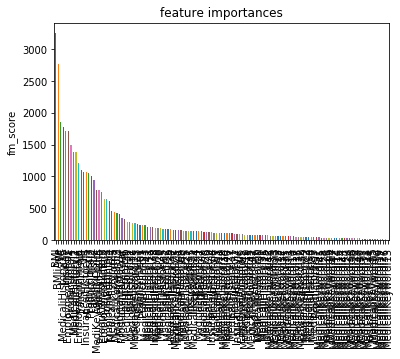

In [33]:
train_part, test_part = train_test_split(train, test_size=0.2)
X1=train_part
X1['Response'] -= 1
%time modelfit0(xgbc,X1,predictors)

In [31]:
train_part['Response'].value_counts()

7    15594
5     9036
6     6426
1     5195
0     4994
4     4286
3     1154
2      819
Name: Response, dtype: int64